<h1>The heterogeneity and robustness of the Kuznets curve

https://docs.google.com/document/d/1M99QQbTWXdMceAiBRSqCsgX0dTrR9O3X50fAD2F2QrA/edit

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import skew, kurtosis
import arch.unitroot as ur
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima import auto_arima


In [17]:
df = pd.read_csv('china.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('[^\\w\\s]','')
df = df.rename(columns={'time' : 'year', 'gdp_per_capita_(current_us$)_[ny.gdp.pcap.cd]' : 'gdp', 'co2_emissions_(metric_tons_per_capita)_[en.atm.co2e.pc]' : 'co2', 'gini_index_[si.pov.gini]' : 'gini'})
df = df.replace('..', np.nan).dropna()

cols = ['gdp', 'co2', 'gini']
for col in cols:
    df[col] = pd.to_numeric(df[col])

data_skewness = skew(df)
data_kurtosis = kurtosis(df)

print(f"Skewness: {data_skewness}")
print(f"Kurtosis: {data_kurtosis}")

for col in cols:
    df[col] = np.log(df[col])

df.describe()

Skewness: [-0.70422531 -0.1037755  -0.69096109 -0.53360727]
Kurtosis: [-0.7244388  -1.49569853 -1.25917762 -0.22849988]


,year,gdp,co2,gini
count,18.000000,18.000000,18.000000,18.000000
mean,2008.777778,8.137163,1.627734,3.662020
std,9.258100,1.150227,0.501940,0.081900
min,1990.000000,5.850990,0.649481,3.471966
25%,2002.750000,7.151998,1.189331,3.644791
50%,2011.500000,8.690742,1.942032,3.660981
75%,2015.750000,8.996507,1.985817,3.731035
max,2020.000000,9.250399,2.048485,3.777348


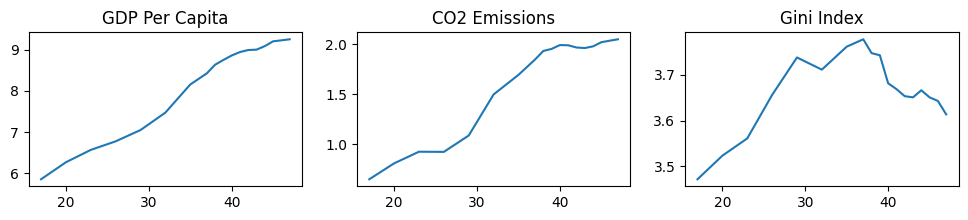

In [18]:
fig, ax = plt.subplots(1, 3, figsize = (12,2))
ax[0].plot(df['gdp'])
ax[0].set_title("GDP Per Capita")
ax[1].plot(df['co2'])
ax[1].set_title("CO2 Emissions")
ax[2].plot(df['gini'])
ax[2].set_title("Gini Index")
plt.show()

<h1>Kuznets Curve

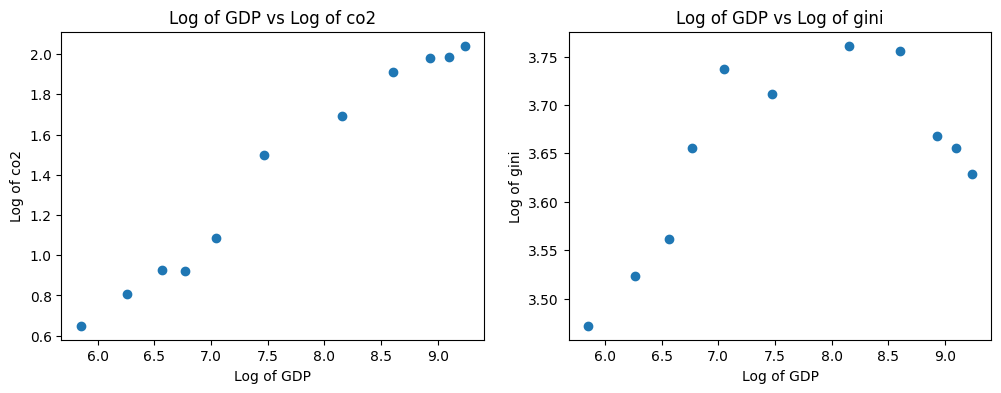

In [19]:
df['year_group'] = df['year'] // 3 * 3
avr_df = df.groupby('year_group')[['gdp','co2', 'gini']].mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize = (12,4))

ax[0].scatter(avr_df['gdp'], avr_df[cols[1]])
ax[0].set_xlabel('Log of GDP')
ax[0].set_ylabel(f'Log of {cols[1]}')
ax[0].set_title(f'Log of GDP vs Log of {cols[1]}')

ax[1].scatter(avr_df['gdp'], avr_df[cols[2]])
ax[1].set_xlabel('Log of GDP')
ax[1].set_ylabel(f'Log of {cols[2]}')
ax[1].set_title(f'Log of GDP vs Log of {cols[2]}')

plt.show()

<h1>Stationary Test

In [20]:
for col in cols:
    series = df[col].values
    adf_y = ur.ADF(series)
    print(f'\n///////////////////{col}///////////////////////')
    print(adf_y.summary())


///////////////////gdp///////////////////////
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.966
P-value                         0.002
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.89 (1%), -3.05 (5%), -2.67 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

///////////////////co2///////////////////////
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.079
P-value                         0.253
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: -4.22 (1%), -3.19 (5%), -2.73 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

///////////////////gini///////////////////////
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.686
P-value                         0.076
Lags  

c:\Users\frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]
c:\Users\frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]
c:\Users\frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (

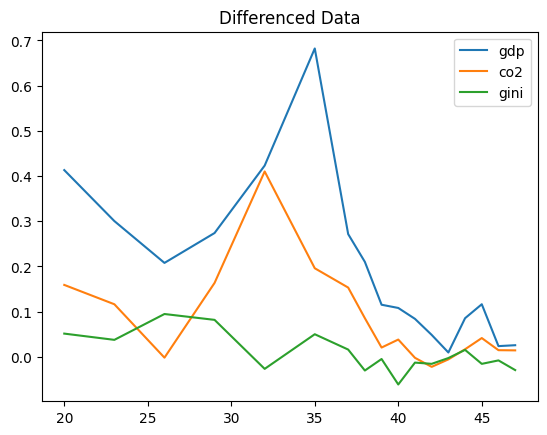

In [21]:
df_diff = df[cols].diff()
df_diff.plot()
plt.title('Differenced Data')
plt.show()

<h1>Differenced Data

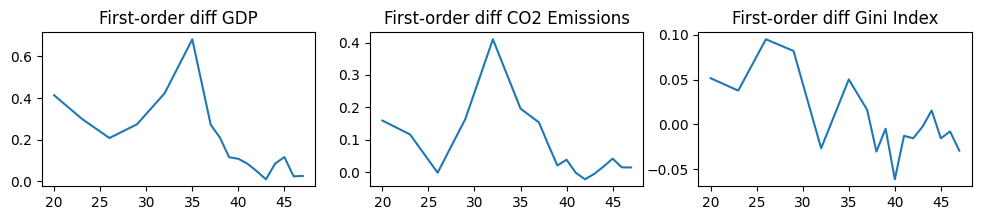

In [22]:
# Perform first-order differencing
df_diff_gdp = df["gdp"].diff(periods=1).dropna()
df_diff_co2 = df["co2"].diff(periods=1).dropna()
df_diff_gini = df["gini"].diff(periods=1).dropna()

fig, ax = plt.subplots(1, 3, figsize = (12,2))
ax[0].plot(df_diff_gdp)
ax[0].set_title("First-order diff GDP")
ax[1].plot(df_diff_co2)
ax[1].set_title("First-order diff CO2 Emissions")
ax[2].plot(df_diff_gini)
ax[2].set_title("First-order diff Gini Index")
plt.show()

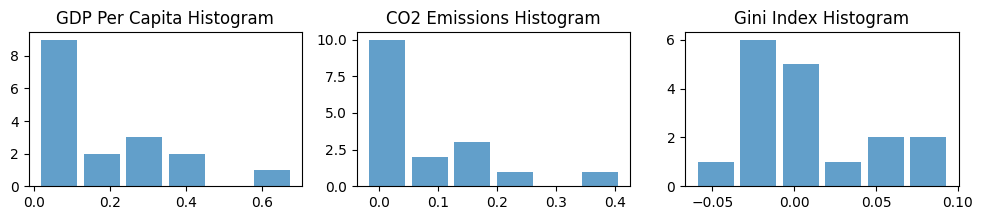

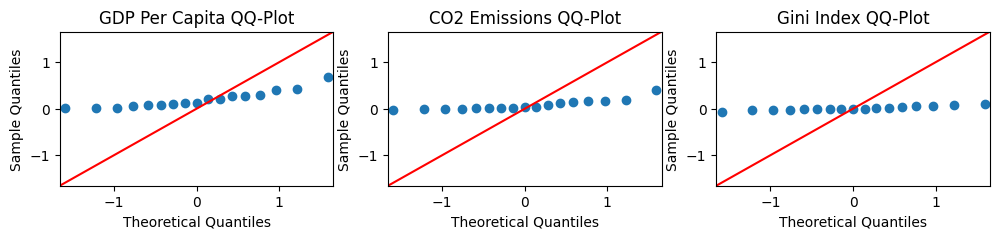

In [23]:
gdp = df_diff_gdp
co2 = df_diff_co2
gini = df_diff_gini

fig, ax = plt.subplots(1, 3, figsize = (12,2))
ax[0].hist(gdp, bins='auto', alpha=0.7, rwidth=0.85)
ax[0].set_title("GDP Per Capita Histogram")
ax[1].hist(co2, bins='auto', alpha=0.7, rwidth=0.85)
ax[1].set_title("CO2 Emissions Histogram")
ax[2].hist(gini, bins='auto', alpha=0.7, rwidth=0.85)
ax[2].set_title("Gini Index Histogram")
plt.show()

fig, ax = plt.subplots(1, 3, figsize = (12,2))
sm.qqplot(gdp, line='45', ax=ax[0])
ax[0].set_title("GDP Per Capita QQ-Plot")
sm.qqplot(co2, line='45', ax=ax[1])
ax[1].set_title("CO2 Emissions QQ-Plot")
sm.qqplot(gini, line='45', ax=ax[2])
ax[2].set_title("Gini Index QQ-Plot")
plt.show()

In [24]:
cols_diff = [gdp, co2, gini]
i = 0
for col in cols_diff:
    print(f'\n//////////////////////{cols[i]}////////////////////')
    shapiro_test = stats.shapiro(col)
    print(f"Shapiro test statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")
    ks_test = stats.kstest(col, 'norm')
    print(f"KS test statistic: {ks_test.statistic}, p-value: {ks_test.pvalue}")
    i += 1


//////////////////////gdp////////////////////
Shapiro test statistic: 0.875199019908905, p-value: 0.02660316228866577
KS test statistic: 0.5038601526507895, p-value: 0.00016081174147754488

//////////////////////co2////////////////////
Shapiro test statistic: 0.8009331226348877, p-value: 0.0020893358159810305
KS test statistic: 0.4911886727121926, p-value: 0.000262727161339641

//////////////////////gini////////////////////
Shapiro test statistic: 0.939559280872345, p-value: 0.31299644708633423
KS test statistic: 0.47565211545600244, p-value: 0.0004693631371046614


<h1>ACF and PACF

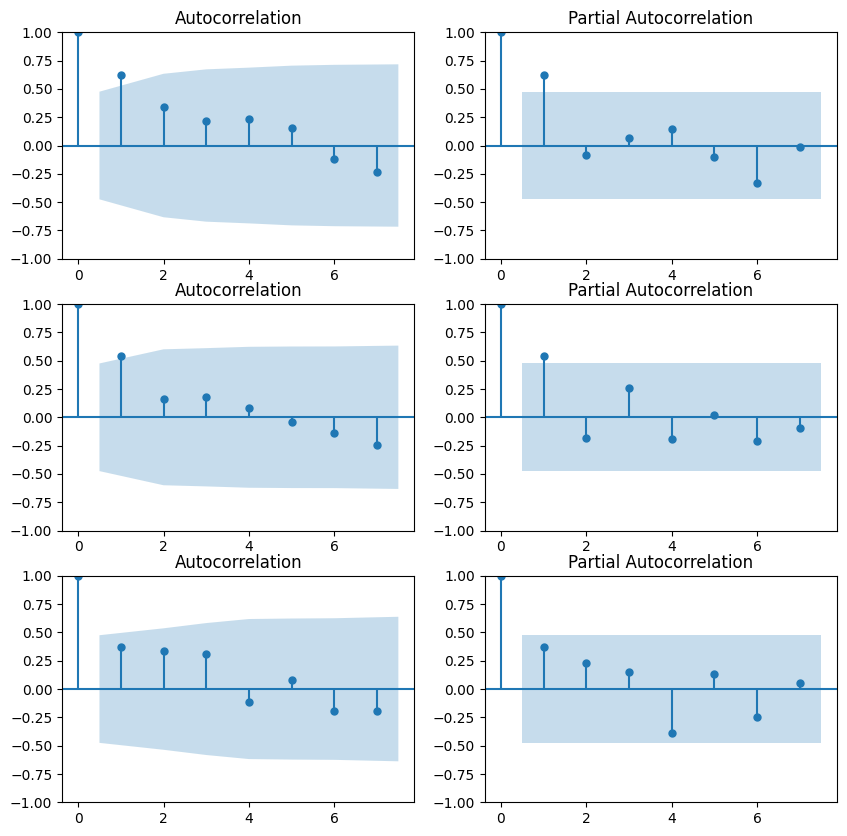

In [25]:
fig, ax = plt.subplots(3, 2, figsize = (10,10))
sm.graphics.tsa.plot_acf(gdp, lags=7, ax=ax[0, 0])
sm.graphics.tsa.plot_pacf(gdp, lags=7, ax=ax[0, 1])
sm.graphics.tsa.plot_acf(co2, lags=7, ax=ax[1, 0])
sm.graphics.tsa.plot_pacf(co2, lags=7, ax=ax[1, 1])
sm.graphics.tsa.plot_acf(gini, lags=7, ax=ax[2, 0])
sm.graphics.tsa.plot_pacf(gini, lags=7, ax=ax[2, 1])
plt.show()

<h1>Auto ARIMA, Forecasts, LJ Test, MSE, MAE, MAPE

In [29]:
train, test = train_test_split(gdp, test_size=0.2, shuffle=False)
# Find the optimal ARIMA model for the train set
model = auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, m=7, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
print(model.summary())

print('\n\n//////////////////////////////////////////////////////////')
# Check the residuals
residuals = model.resid()
sm.graphics.tsa.plot_acf(residuals, lags=7)  # adjust the number of lags here
plt.show()
lj = sm.stats.acorr_ljungbox(residuals, lags=[7], return_df=True)
print(lj)

print('\n\n//////////////////////////////////////////////////////////')
start = test.index[0]
end = test.index[-1]
forecasts = model.predict(n_periods=len(test), start=start, end=end)
print('Forecasts:\n', forecasts)
print('Actual values:\n', test)

print('\n\n//////////////////////////////////////////////////////////')
# Calculate the error metrics
rmse = np.sqrt(mean_squared_error(test, forecasts))
mae = mean_absolute_error(test, forecasts)
mape = mean_absolute_percentage_error(test, forecasts)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)

ValueError: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.

<h1>OLS

In [28]:
df['gdp_squared'] = df['gdp']**2
formula = 'gini ~ gdp + gdp_squared'
model = smf.ols(formula, data=df)
ols = model.fit()

print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:                   gini   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     59.07
Date:                Wed, 03 Jan 2024   Prob (F-statistic):           7.74e-08
Time:                        15:27:13   Log-Likelihood:                 39.664
No. Observations:                  18   AIC:                            -73.33
Df Residuals:                      15   BIC:                            -70.66
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.9562      0.471     -2.031      

c:\Users\frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [27]:
df['gdp_squared'] = df['gdp']**2
formula = 'co2 ~ gdp + gdp_squared'
model = smf.ols(formula, data=df)
ols = model.fit()

print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     459.9
Date:                Wed, 03 Jan 2024   Prob (F-statistic):           3.47e-14
Time:                        15:26:55   Log-Likelihood:                 24.572
No. Observations:                  18   AIC:                            -43.14
Df Residuals:                      15   BIC:                            -40.47
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.1583      1.089     -3.819      

c:\Users\frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
